In [Stefan et al](https://link.springer.com/article/10.3758/s13423-022-02074-4) the following question was asked

> (1). Imagine how general small-to-medium effect sizes in your field would look like. Which effect size would you expect as the most probable one to be found?
> 
> (2) Which range of values would you consider possible?
> 
> [Then do the Histogram method to place virtual chips on a grid, ten equally spaced bins from 0 to 1 (no limit on number of chips)]

to experts (two each) in the following specialisms:

- social psychologist
- developmental psychologist
- cognitive neuroscientist

Resulting in the following prior distributions. $\alpha$ and $\beta$ refer to a beta prior for the unsigned Pearson correlation coefficient; $\mu$, $\sigma$ and $\nu$ are parameters of a Student's t-distribution for a standardized effect size measure, Cohen's $\delta$.

In [2]:
# Data from the paper:
stefan = [
    {"Expert": 1, "Field": "Social Psychology", "α": 0.62, "β": 22.44, "μ": 0.10, "σ": 0.12, "ν": 3},
    {"Expert": 2, "Field": "Social Psychology", "α": 5.32, "β": 18.58, "μ": 0.55, "σ": 0.08, "ν": 3},
    {"Expert": 3, "Field": "Cognitive Neuroscience", "α": 5.35, "β": 15.69, "μ": 0.60, "σ": 0.11, "ν": 13},
    {"Expert": 4, "Field": "Cognitive Neuroscience", "α": 10.70, "β": 22.98, "μ": 0.59, "σ": 0.11, "ν": 3},
    {"Expert": 5, "Field": "Developmental Psychology", "α": 3.83, "β": 8.76, "μ": 0.41, "σ": 0.12, "ν": 13},
    {"Expert": 6, "Field": "Developmental Psychology", "α": 8.65, "β": 12.39, "μ": 0.31, "σ": 0.08, "ν": 9}
]

Our own experiments with LLMs resulted in the following distributions.

In [3]:
import json
import pandas as pd
from pathlib import Path

def load_ndjson(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            obj = json.loads(line.strip())
            data.append(obj)
    return data

def jsonlist_to_df(jsonlist):
    dflist = map(pd.DataFrame, jsonlist)
    return pd.concat(dflist).reset_index()

def read_ndjson(filename):
    data = load_ndjson(filename)
    return jsonlist_to_df(data)

data_dir = Path('../../data/output/elicitation')
psych_path = data_dir / 'psychology.ndjson'
llm_priors = read_ndjson(psych_path)
llm_priors.head()

,index,field,target,dist,params,model,role,shelf,roulette,timestamp
0,0,social psychology,cohen,student_t,"{'loc': 0.2, 'scale': 0.5, 'df': 10}",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:23:57
1,1,social psychology,pearson,beta,"{'alpha': 0.1, 'beta': 0.3}",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:23:57
2,2,developmental psychology,cohen,student_t,"{'loc': 0.2, 'scale': 0.5, 'df': 10}",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:23:57
3,3,developmental psychology,pearson,beta,"{'alpha': 0.1, 'beta': 0.5}",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:23:57
4,4,cognitive neuroscience,cohen,student_t,"{'loc': 0.2, 'scale': 0.5, 'df': 10}",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:23:57


In [4]:
import numpy as np
from plotnine import *
from scipy import stats
import matplotlib.pyplot as plt
import plotnine

plotnine.options.figure_size = (8, 4)
theme_set(theme_bw())

def geom_beta(a, b, **kwargs):
    return stat_function(fun=stats.beta(a=a, b=b).pdf, xlim=(.01, .99), **kwargs)

def geom_studentT(loc, scale, df, **kwargs):
    return stat_function(fun=stats.t(loc=loc, scale=scale, df=df).pdf, xlim=(.01, .99), **kwargs)

def expert(name):
    return pd.DataFrame({'expert': [name]})

def abbr_model(model_name):
    lookup = {'mistralai/Mistral-7B-Instruct-v0.2': 'Mistral-7B-Instruct',
              'llama-2-70b-chat.Q5_K_M': 'Llama-2-70B',
              'meta-llama/Llama-2-13b-chat-hf': 'Llama-2-13B',
              'gpt-4': 'GPT-4'}
    if model_name in lookup:
        return lookup[model_name]
    else:
        return model_name

In [5]:
# Alternative approach
plot_data = pd.DataFrame()
x = np.linspace(0, 1, 100)

for idx, row in llm_priors.iterrows():
    if row.dist=='student_t':
        df, loc, scale = row.params['df'], row.params['loc'], row.params['scale']
        y = stats.t(df=df, loc=loc, scale=scale).pdf(x)
    elif row.dist=='beta':
        a, b = row.params['alpha'], row.params['beta']
        y = stats.beta(a, b).pdf(x)
    else:
        raise NotImplementedError(f'distribution {row.dist} not recognized')
    dct = dict(row.copy(), x=x, y=y, idx=idx, model_short=abbr_model(row.model))
    dct.pop('params')
    dat = pd.DataFrame(dct)
    plot_data = pd.concat([plot_data, dat])

for human in stefan:
    a, b, df, loc, scale = human['α'], human['β'], human['ν'], human['μ'], human['σ']
    for dist in ['student_t', 'beta']:
        y = stats.beta(a=a, b=b).pdf(x) if dist=='beta' else stats.t(df=df, loc=loc, scale=scale).pdf(x)
        dct = {'model': 'Human', 'model_short': 'Human', 'dist': dist, 'idx': -human['Expert'], 'role': 'expert',
               'field': human['Field'].lower(), 'shelf': False, 'x': x, 'y': y, 'roulette': False}
        dat = pd.DataFrame(dct)
        plot_data = pd.concat([plot_data, dat])

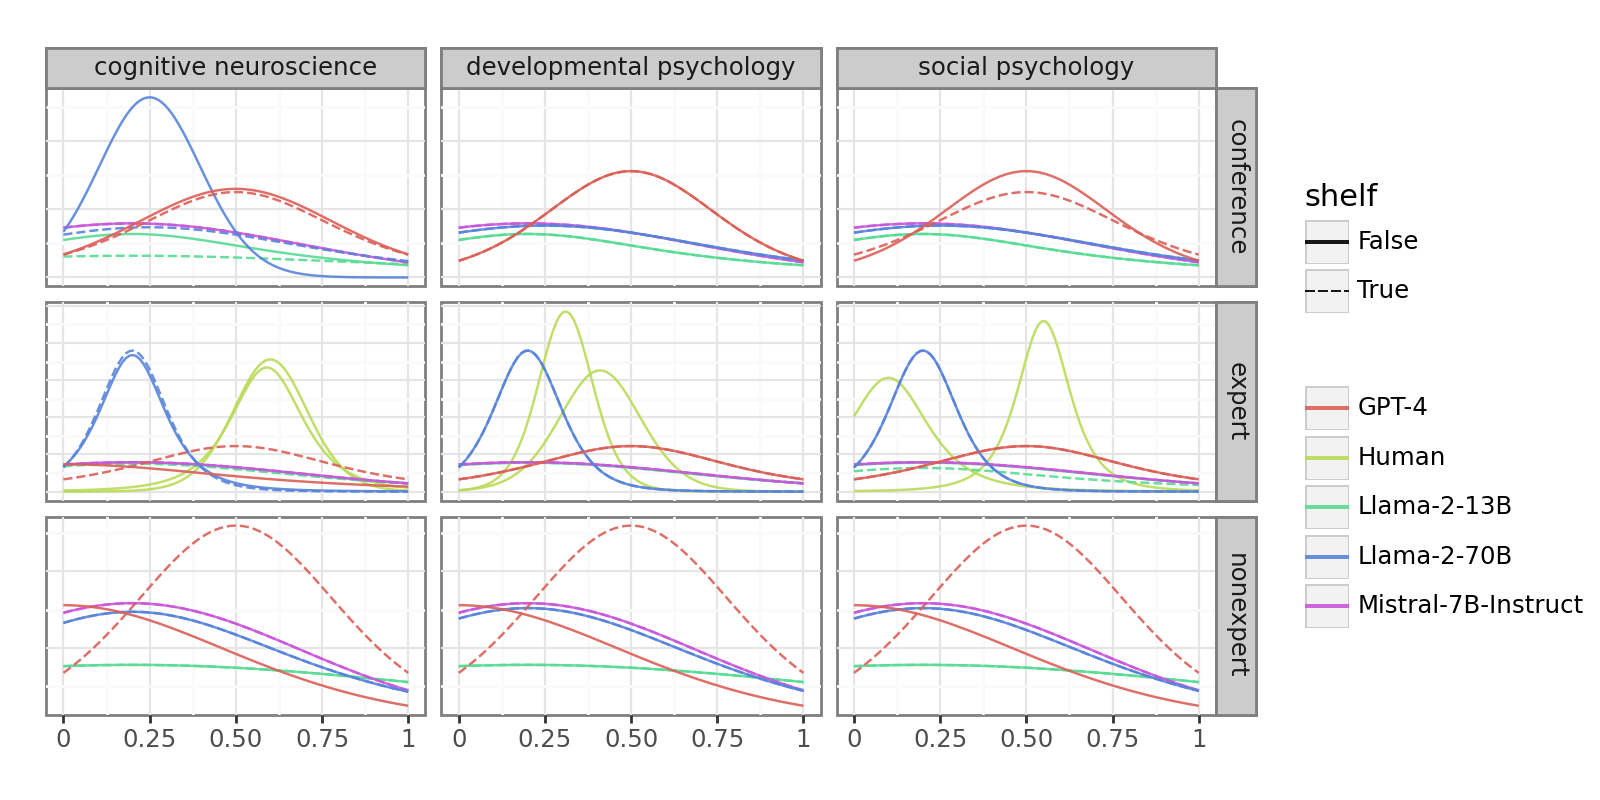

<Figure Size: (800 x 400)>

In [6]:
gg = (ggplot(plot_data[(plot_data.dist=='student_t') & (~plot_data.roulette)]) +
      aes('x', 'y', colour='model_short', group='idx', linetype='shelf') +
      geom_line(alpha = .9) +
      facet_grid('role~field', scales='free_y') +
      theme(legend_position='right') +
      guides(colour=guide_legend(ncol=1)) +
      labs(x = '', y = '', colour='') +
      theme(#legend_title=element_blank(),
            axis_ticks_major_y=element_blank(),
            axis_ticks_minor_y=element_blank(),
            axis_text_y=element_blank())
)
   
gg

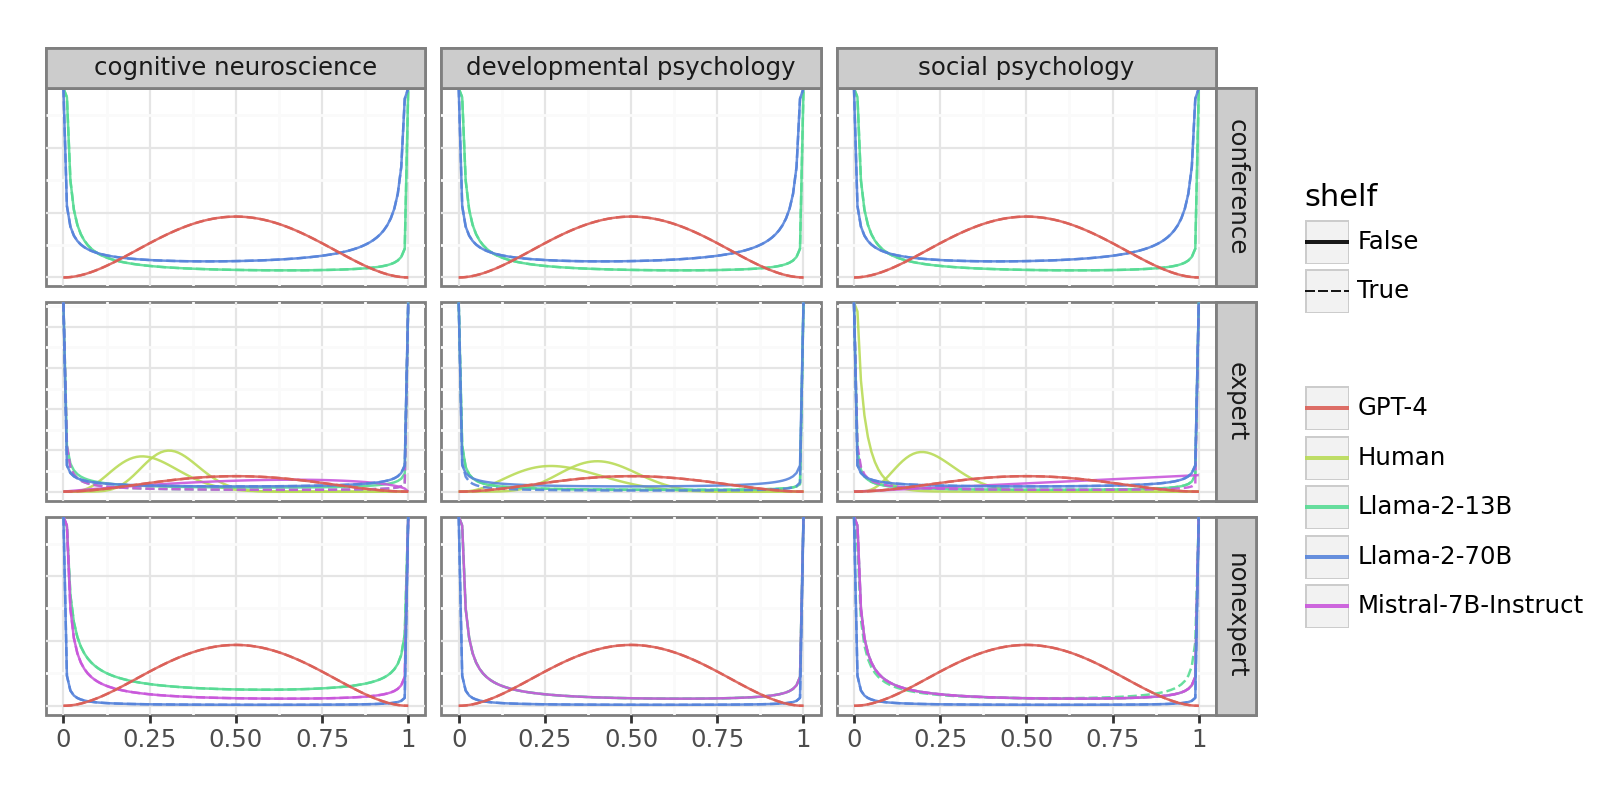

<Figure Size: (800 x 400)>

In [7]:
gg = (ggplot(plot_data[(plot_data.dist=='beta') & (~plot_data.roulette)]) +
      aes('x', 'y', colour='model_short', group='idx', linetype='shelf') +
      geom_line(alpha = .9) +
      facet_grid('role~field', scales='free_y') +
      theme(legend_position='right') +
      guides(colour=guide_legend(ncol=1)) +
      labs(x = '', y = '', colour='') +
      theme(#legend_title=element_blank(),
            axis_ticks_major_y=element_blank(),
            axis_ticks_minor_y=element_blank(),
            axis_text_y=element_blank())
)
   
gg

Occasional missing values appear to be caused by LLMs, especially Mistral, attempting to set $\alpha=0.0$ for the beta distribution. While not a missing value, this isn't a valid parameter either and results in no curve being plotted. It appears to be only an issue for decision conferences.

The roulette method is also a challenge.